https://thefiddler.substack.com/p/can-you-fairly-cut-the-birthday-cake

For all those special people who have birthdays this month, here’s a fun geometry puzzle from Friend-of-The-Fiddler Dean Ballard:

You and two friends all have March birthdays, so you’ve decided to celebrate together with one big cake that has delicious frosting around its perimeter. To share the cake fairly, you want to ensure that (1) each of you gets the same amount of cake, by area, and (2) each of you gets the same amount of frosting along the cake’s edge.

What’s more, you want to cut the cake by starting at a single point inside of it, and then making three straight cuts to the edge from that point. You’ve already worked out ways to do this for circular and square cakes, as shown below.

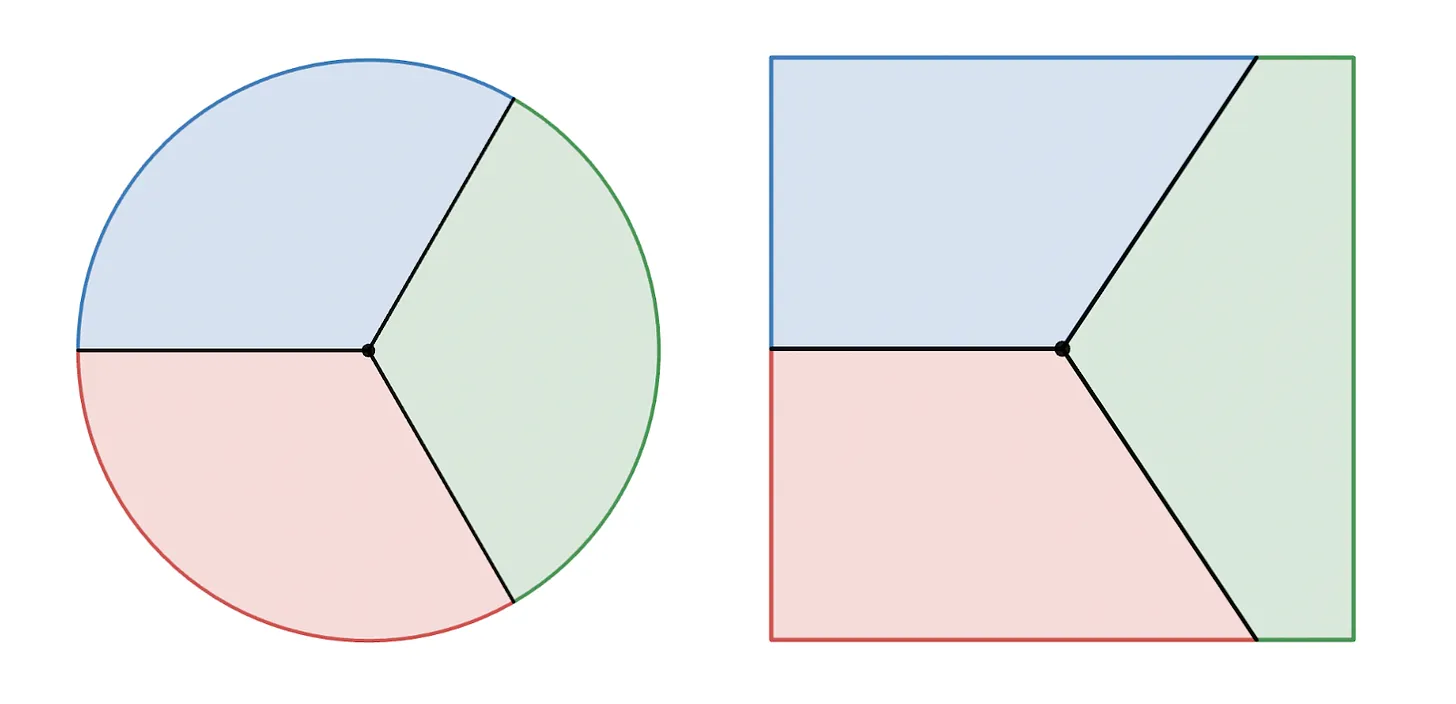

Left: A circle split into thirds by three equally spaced radial cuts. Right: A square with three cuts emanating from the center. One cut is directly left. The other two cuts are symmetric across the horizontal axis. One goes up and to the right, the other down and to the right. The three regions formed by these cuts have equal area and equal portions of the square's perimeter.
However, the cake you bought is rectangular, with a length of 20 inches and a width of 10 inches. Using the coordinate system of your choice, describe a way this particular cake can be cut fairly, so that all three of you get the same amount in terms of both area and the cake’s perimeter. Again, there should be three straight cuts emanating from a single point inside the cake.

To be clear, the three pieces themselves need not have the same perimeter. Instead, each piece must have the same amount of the perimeter from original, uncut cake.

In [13]:
import numpy as np
import scipy
import torch
from IPython.display import display, HTML

In [2]:
WIDTH = 20
HEIGHT = 10

def split(x, y, a):
    """Split rectangle.
    """

    x1, y1 = increment(0, 0, a)
    perimeter_spacing = (HEIGHT + WIDTH) * 2 / 3
    if x < 0 or x > WIDTH:
        raise ValueError("Center point (x) is outside of bounds!")
    if y < 0 or y > HEIGHT:
        raise ValueError("Center point (y) is outside of bounds!")
    # if ((x1 > 0) and (x1 < WIDTH)) and not ((y1 == 0) or (y1 == HEIGHT)):
    #     raise ValueError("Second point must be on perimeter!")
    if a < 0 or a > perimeter_spacing:
        raise ValueError("a is too short or long!")

    x2, y2 = increment(x1, y1, perimeter_spacing)
    x3, y3 = increment(x2, y2, perimeter_spacing)
    
    return x1, y1, x2, y2, x3, y3


def increment(x, y, a):
    """Go to next point by covering length a on perimeter.
    """
    if x==0:
        if y==HEIGHT and a < WIDTH:
            return x+a, y
        elif y==HEIGHT:
            return increment(WIDTH, y, a-WIDTH)
        elif a < (HEIGHT - y):
            return x, y+a
        else:
            return increment(x, HEIGHT, a - (HEIGHT-y))
    elif x==WIDTH:
        if y==0 and a < WIDTH:
            return x-a, y
        elif y==0:
            return increment(0, y, a-WIDTH)
        elif a < y:
            return x, y-a
        else:
            return increment(x, 0, a - y)
    elif y==0:
        if a < x:
            return x - a, y
        else:
            return increment(0, 0, a - x)
    else:
        if a < (WIDTH - x):
            return x + a, y
        else:
            return increment(WIDTH, y, a - (WIDTH - x))


def plot_split(x, y, a):
    x1, y1, x2, y2, x3, y3 = split(x, y, a)
    print(total_loss(x, y, a))
    display(HTML(
        f"""
        <html>
        <svg viewBox="0 0 100 100">
          <rect width="{WIDTH}" height="{HEIGHT}" fill="lightblue" style="stroke:black; stroke-width:.1"/>
          <line x1="{x}" y1="{y}" x2="{x1}" y2="{y1}" style="stroke:black; stroke-width:.2"/>
          <line x1="{x}" y1="{y}" x2="{x2}" y2="{y2}" style="stroke:black; stroke-width:.2"/>
          <line x1="{x}" y1="{y}" x2="{x3}" y2="{y3}" style="stroke:black; stroke-width:.2"/>
        </svg>
        </html>
        """
        ))
                                    

In [3]:
from shapely.geometry import Polygon

def area_loss(area1, area2):
    """Calculate loss given area of first two slices.
    """
    area3 = WIDTH*HEIGHT - area1 - area2
    return (area1 - area3)**2 + (area1 - area2)**2 


def area(points):
    """Area of a concave polygon given vertices in clockwise order.
    """
    # Shoelace algo
    # x = np.array([x[0] for x in points])
    # y = np.array([y[1] for y in points])
    # return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))
    return Polygon(points).area


def total_loss(x, y, a, verbose=False):
    """Calculate total loss. To be used for optimization.
    """
    x1, y1, x2, y2, x3, y3 = split(x, y, a)

    # area1 = x*y+.5*(y1-y)*x+.5*(x3-x)*y
    # return ((HEIGHT*WIDTH/3) - area1)**2
    if y1 == HEIGHT:
        area1 = area([(0,0), (0, HEIGHT), (x1, y1), (x, y), (x3, y3)])
        area2 = area([(x1, y1), (WIDTH, HEIGHT), (x2, y2), (x, y)])
    else:
        area1 = area([(0,0), (x1, y1), (x, y), (x3, y3)])
        area2 = area([(x1, y1), (0, HEIGHT), (x2, y2), (x, y)])

    if verbose:
        print(area1, area2, WIDTH*HEIGHT - area1 - area2)

    return area_loss(area1, area2)

In [4]:
total_loss(10, 5, 1, True)

52.5 72.5 75.0


906.25

In [5]:
total_loss(10, 5, 6, True)

65.0 60.0 75.0


125.0

In [6]:
assert(area([(0, 0), (0, 1), (1, 1), (1,0)]) == 1)

In [7]:
assert(increment(0, 0, 1) == (0, 1))
assert(increment(0, 0, 11) == (1, 10))
assert(increment(20, 10, 11) == (19, 0))
assert(increment(5, 0, 20) == (5, 10))

In [8]:
split(10, 5, 1)

(0, 1, 11.0, 10, 19.0, 0)

In [9]:
plot_split(10, 5, 1)

906.25


In [10]:
plot_split(10, 5, 5)

156.25


In [11]:
plot_split(5, 5, 5)

2500.0


In [14]:
#optimize total_loss
scipy.optimize.fmin(lambda x: total_loss(10, 5, x), 4, maxiter=100)

Optimization terminated successfully.
         Current function value: 125.000000
         Iterations: 17
         Function evaluations: 34


array([6.])

In [15]:
scipy.optimize.fmin(lambda x: total_loss(x, 5, 5), 1, maxiter=100)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 23
         Function evaluations: 46


array([11.66669922])

In [16]:
results = scipy.optimize.minimize(lambda x: total_loss(x[0], x[1], x[2]), (10, 5, 5))
print(results)
plot_split(*results.x)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 4.234163983410632e-14
        x: [ 1.145e+01  5.676e+00  3.430e+00]
      nit: 11
      jac: [-1.958e-06  3.561e-08 -5.282e-07]
 hess_inv: [[ 7.455e-03 -2.855e-03  5.110e-03]
            [-2.855e-03  1.645e-02 -3.950e-02]
            [ 5.110e-03 -3.950e-02  1.056e-01]]
     nfev: 48
     njev: 12
4.234163983410632e-14


In [17]:
results = scipy.optimize.minimize(lambda x: total_loss(x[0], x[1], x[2]), (5, 5, 5))
print(results)
plot_split(*results.x)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 5.951604273183525e-14
        x: [ 1.089e+01  3.768e+00  8.135e+00]
      nit: 10
      jac: [-1.056e-06  7.093e-06  8.970e-07]
 hess_inv: [[ 5.622e-03 -2.050e-03 -2.407e-03]
            [-2.050e-03  3.665e-03 -4.294e-03]
            [-2.407e-03 -4.294e-03  1.885e-02]]
     nfev: 56
     njev: 14
5.951604273183525e-14


In [18]:
n = 10000
mins = []
for x, y, a in np.random.rand(n, 3)*[WIDTH, HEIGHT, WIDTH*HEIGHT/3]:
    try:
        results = scipy.optimize.minimize(lambda x: total_loss(x[0], x[1], x[2]), (x, y, a))
        if results.fun < .01:
            mins.append(results.x)
    except:
        pass
len(mins)

542

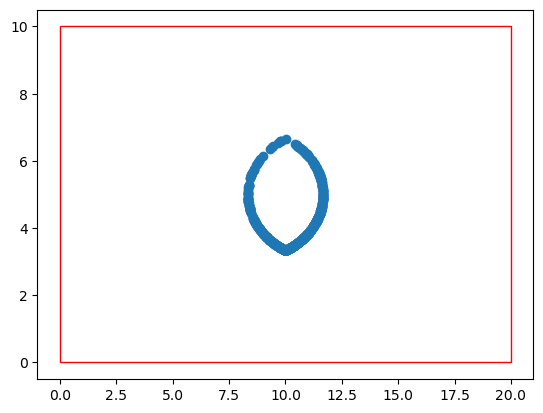

In [19]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(1)
x = np.array([x[0] for x in mins])
y = np.array([x[1] for x in mins])
ax.scatter(x, y)
ax.add_patch(Rectangle((0, 0), WIDTH, HEIGHT, facecolor='none', edgecolor='red'))